### Load required packages

In [1]:
import os
import warnings
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.n_jobs = 32
warnings.filterwarnings("ignore")

pwd = os.getcwd()

Global seed set to 0


In [2]:
adata_mvi = anndata.read_h5ad(filename="multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated.h5ad")

### Recalculate QC metrics for NAs in rna_neighbors_qc_ratio and label_transfer

In [3]:
np.where(adata_mvi.obs["rna_neighbors_qc_ratio"].isnull())[0].shape

(286679,)

In [6]:
adata_mvi.obs["rna_neighbors_qc_ratio_new"] = adata_mvi.obs["rna_neighbors_qc_ratio"]

In [7]:
def compute_cell_quality_all_neighbors(adata_mvi, cell_idx):
    idx = np.where(adata_mvi.uns['neighbors']['connectivities'][cell_idx].todense()>0)[1]
    df = adata_mvi.obs[["rna_neighbors_qc_ratio_new", "modality"]].iloc[idx]
    ratio = df["rna_neighbors_qc_ratio_new"].mean(skipna=True)
    return ratio

for i in np.where(adata_mvi.obs["rna_neighbors_qc_ratio_new"].isnull())[0]:
    adata_mvi.obs["rna_neighbors_qc_ratio_new"][i] = compute_cell_quality_all_neighbors(adata_mvi, i)

print(adata_mvi.obs["rna_neighbors_qc_ratio_new"].isnull().sum())

1027


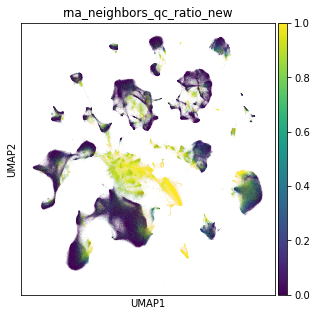

In [8]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_mvi, color="rna_neighbors_qc_ratio_new")

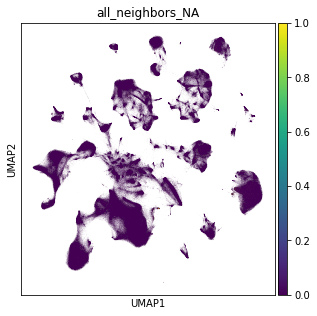

In [9]:
adata_mvi.obs["all_neighbors_NA"] = adata_mvi.obs["rna_neighbors_qc_ratio_new"].isnull() * 1.0

sc.pl.umap(adata_mvi, color="all_neighbors_NA")

In [10]:
adata_mvi.obs["label_transfer"].unique()

['L5 IT', 'L6 IT', 'Pvalb', 'Micro-PVM', 'L6 CT', ..., 'Sncg', 'Endo', 'Pax6', 'L5 ET', 'NA']
Length: 25
Categories (25, object): ['Astro', 'Chandelier', 'Endo', 'L2/3 IT', ..., 'Sst', 'Sst Chodl', 'VLMC', 'Vip']

In [27]:
def compute_label_purity_slot(adata_mvi, cell_idx, slot="subclass_scANVI"):
    idx = np.where(adata_mvi.uns['neighbors']['connectivities'][cell_idx].todense()>0)[1]
    df = adata_mvi.obs[[slot]].iloc[idx]
    df = df.loc[~df[slot].isnull()]
    u, c = np.unique(df, return_counts=True)
    if np.size(c) == 0:
        ratio = 0
        label = np.nan
    else:
        ratio = c[np.argmax(c)] / c.sum()
        label = u[np.argmax(c)]
    
    return ratio, label

In [12]:
cells = adata_mvi.shape[0]
purity_ratios = np.zeros(cells)
labels = adata_mvi.obs["subclass_scANVI"].to_numpy()
for i in np.arange(cells):
    ratio, label_ = compute_label_purity_slot(adata_mvi, i, slot="subclass_scANVI")
    purity_ratios[i] = ratio
    labels[i] = label_

adata_mvi.obs["subclass_purity_ratio"] = purity_ratios
adata_mvi.obs["label_transfer"] = labels

In [13]:
for i in np.where(adata_mvi.obs["label_transfer"].isnull())[0]:
    ratio, label_ = compute_label_purity_slot(adata_mvi, i, slot="label_transfer")
    adata_mvi.obs["subclass_purity_ratio"].loc[i] = ratio
    adata_mvi.obs["label_transfer"].loc[i] = label_

In [14]:
print(adata_mvi.obs["label_transfer"].isnull().sum())

286679


In [15]:
adata_mvi.write("multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated.h5ad")

... storing 'label_transfer' as categorical


### Choose cutoff value 0.2

In [16]:
adata_mvi.obs['leiden_1.0'].unique()
# adata_1 = adata_mvi[adata_mvi.obs['leiden_1.0'].isin(['0'])]
# adata_mvi.obs.groupby(['leiden_1.0']).size()

['4', '10', '11', '21', '24', ..., '40', '44', '36', '45', '47']
Length: 48
Categories (48, object): ['0', '1', '2', '3', ..., '44', '45', '46', '47']

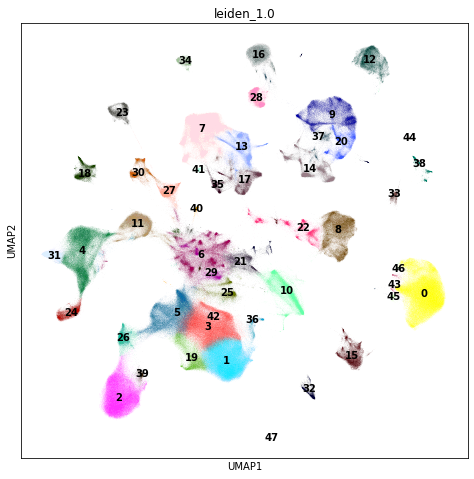

In [19]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.umap(adata_mvi, color=['leiden_1.0'], legend_loc='on data') ## this is default resolution

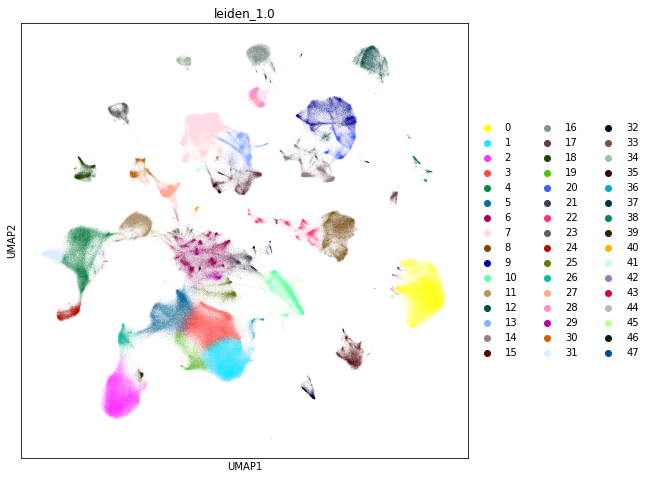

In [40]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.umap(adata_mvi, color=['leiden_1.0'])

In [16]:
bad_clusters = ['33', '22', '21', '6', '29', '10', '25', '36', '39', '47', '32']

In [17]:
cut_off = (~adata_mvi.obs['leiden_1.0'].isin(bad_clusters)) & (adata_mvi.obs["rna_neighbors_qc_ratio_new"].to_numpy() <= 0.2)

In [26]:
ad = adata_mvi[cut_off].copy()

In [28]:
ad.obs["subclass_purity_ratio_new"] = ad.obs["subclass_purity_ratio"]
ad.obs["label_transfer_new"] = ad.obs["label_transfer"]

for i in np.where(ad.obs["label_transfer_new"].isnull())[0]:
    ratio, label_ = compute_label_purity_slot(ad, i, slot="label_transfer_new")
    ad.obs["subclass_purity_ratio_new"].loc[i] = ratio
    ad.obs["label_transfer_new"].loc[i] = label_

In [44]:
print(ad.obs["label_transfer"].isnull().sum())

167005


In [29]:
print(ad.obs["label_transfer_new"].isnull().sum())

167005


In [50]:
np.array_equal(np.where(ad.obs["label_transfer"].isnull())[0], np.where(ad.obs["label_transfer_new"].isnull())[0], equal_nan=False)

True

In [59]:
print(np.sum(ad.obs["label_transfer"] == ad.obs["label_transfer_new"]) + ad.obs["label_transfer_new"].isnull().sum())
print(ad.obs.shape[0])
print('This demonstrates that "label_transfer" and "label_transfer_new" are identical! So use "label_transfer" for all analysis!')

825782
825782
This demonstrates that "label_transfer" and "label_transfer_new" are identical! So use "label_transfer" for all analysis!


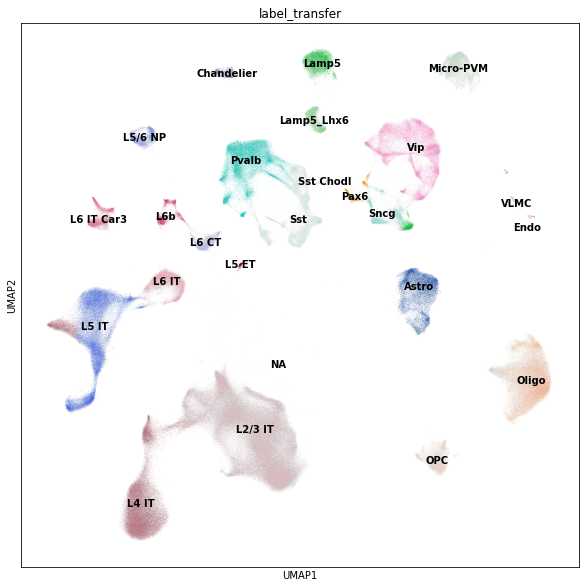

In [31]:
plt.rcParams["figure.figsize"] = (10, 10)
sc.pl.umap(ad, color='label_transfer', legend_loc="on data")

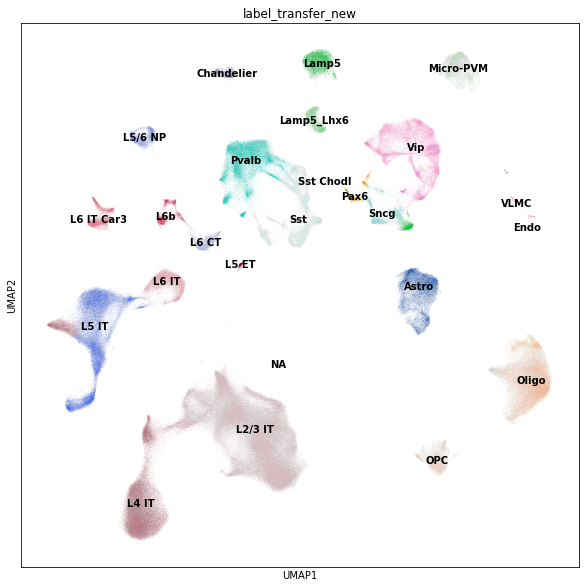

In [35]:
sc.pl.umap(ad, color='label_transfer_new', legend_loc="on data")

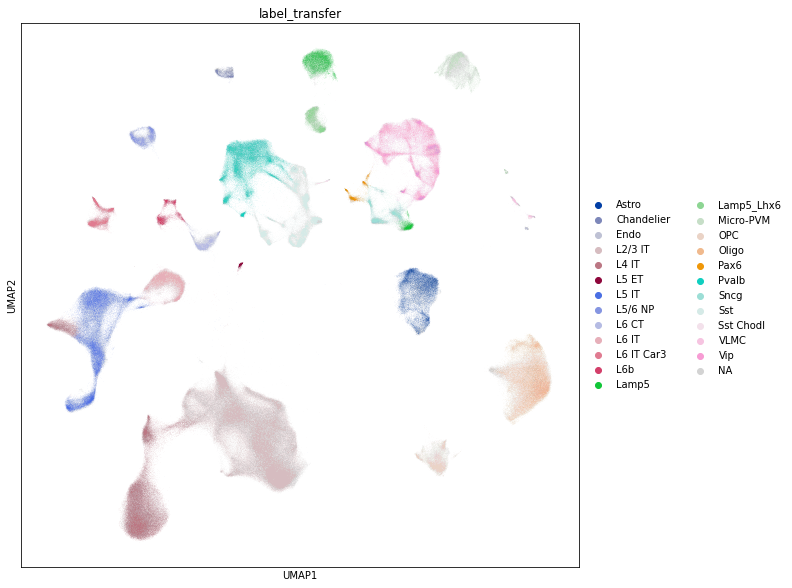

In [39]:
sc.pl.umap(ad, color='label_transfer')

In [42]:
ad.obs[ad.obs['leiden_1.0'].isin(['44'])]["label_transfer_new"].unique()

['Micro-PVM', NaN, 'Endo']
Categories (24, object): ['Astro', 'Chandelier', 'Endo', 'L2/3 IT', ..., 'Sst', 'Sst Chodl', 'VLMC', 'Vip']

In [56]:
ad.obs[["path_to_fragments", "label_transfer", "barcodes_out", "library_prep"]]

,path_to_fragments,label_transfer,barcodes_out,library_prep
AAACAGCCAAACATAG-L8XR_210916_02_B11_paired,/allen/programs/celltypes/production/mousecell...,L5 IT,AAACAGCCAAACATAG-1,L8XR_210916_02_B11
AAACAGCCAAACTGCC-L8XR_210722_01_H07_paired,/allen/programs/celltypes/production/mousecell...,L6 IT,AAACAGCCAAACTGCC-1,L8XR_210722_01_H07
AAACAGCCAAAGCTCC-L8XR_211007_02_C04_paired,/allen/programs/celltypes/production/mousecell...,L5 IT,AAACAGCCAAAGCTCC-1,L8XR_211007_02_C04
AAACAGCCAAATATCC-L8XR_210729_01_D09_paired,/allen/programs/celltypes/production/mousecell...,Pvalb,AAACAGCCAAATATCC-1,L8XR_210729_01_D09
AAACAGCCAACAACAA-L8XR_210902_02_B08_paired,/allen/programs/celltypes/production/mousecell...,Micro-PVM,AAACAGCCAACAACAA-1,L8XR_210902_02_B08
...,...,...,...,...
TTTGGTTGTTATGCAC-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,Lamp5,TTTGGTTGTTATGCAC-1,L8AT_211117_01_F07
TTTGTGTCAAGTTCGT-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,Pvalb,TTTGTGTCAAGTTCGT-1,L8AT_211117_01_F07
TTTGTGTCAGGCATTT-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,L4 IT,TTTGTGTCAGGCATTT-1,L8AT_211117_01_F07
TTTGTGTGTTACCCAA-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,L6b,TTTGTGTGTTACCCAA-1,L8AT_211117_01_F07


In [57]:
ad.write("multivi_AD_3cohorts_RNA_ATAC_Multiome_v2.0_annotation_updated_refined_1.0.h5ad")